<a href="https://colab.research.google.com/github/eisbetterthanpi/pytorch/blob/main/fast.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [9]:
# @title data
import torch
import torch.nn as nn
# import torch.nn.functional as F
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import numpy as np
# https://github.com/python-engineer/pytorchTutorial/blob/master/14_cnn.py

# dataset has PILImage images of range [0, 1], transform them to Tensors of normalized range [-1, 1]
transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])
# transform = transforms.Compose(transforms.ToTensor())

# CIFAR10: 60000 32x32 color images in 10 classes, with 6000 images per class
train_dataset = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)
test_dataset = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=transform)
batch_size = 64 # 4
# train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
# test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=4, pin_memory=True)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=4, pin_memory=True)

classes = ('plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

def imshow(img):
    img = img / 2 + 0.5  # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

dataiter = iter(train_loader) # get some random training images
images, labels = dataiter.next()
# imshow(torchvision.utils.make_grid(images))


Files already downloaded and verified
Files already downloaded and verified


In [10]:
# @title simplifi
# https://github.com/JayPatwardhan/ResNet-PyTorch/blob/master/ResNet/ResNet.py
import torch
import torch.nn as nn
import torch.nn.functional as F


class Block(nn.Module):
    expansion = 1
    def __init__(self, in_channels, out_channels, i_downsample=None, stride=1):
        super(Block, self).__init__()
        self.conv = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1, stride=stride, bias=False),
            nn.BatchNorm2d(out_channels), nn.ReLU(),
            nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1, stride=stride, bias=False),
            nn.BatchNorm2d(out_channels),
        )
        self.i_downsample = i_downsample

    def forward(self, x):
        identity = x.clone()
        x = self.conv(x)
        if self.i_downsample is not None:
            identity = self.i_downsample(identity)
        x += identity
        x = nn.ReLU()(x)
        return x


class Bottleneck(nn.Module):
    expansion = 4
    def __init__(self, in_channels, out_channels, i_downsample=None, stride=1):
        super(Bottleneck, self).__init__()
        self.conv = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size=1, stride=1, padding=0),
            nn.BatchNorm2d(out_channels), nn.ReLU(),
            nn.Conv2d(out_channels, out_channels, kernel_size=3, stride=stride, padding=1),
            nn.BatchNorm2d(out_channels), nn.ReLU(),
            nn.Conv2d(out_channels, out_channels*self.expansion, kernel_size=1, stride=1, padding=0),
            nn.BatchNorm2d(out_channels*self.expansion),
        )
        self.i_downsample = i_downsample
        
    def forward(self, x):
        identity = x.clone()
        x = self.conv(x)
        if self.i_downsample is not None: #downsample if needed
            identity = self.i_downsample(identity)
        x += identity #add identity
        x = nn.ReLU()(x)
        return x


class ResNet(nn.Module):
    def __init__(self, ResBlock, layer_list, num_classes, num_channels=3):
        super(ResNet, self).__init__()
        # https://github.com/akamaster/pytorch_resnet_cifar10/blob/master/resnet.py
        # num_blocks=[3,3,3] aka layer_list
        # plane_list=[64,128,256,512]
        plane_list=[64,128,256]
        # plane_list=[16,32,64]
        self.in_channels = plane_list[0]
        self.conv = nn.Sequential(
            nn.Conv2d(3, plane_list[0], kernel_size=3, stride=1, padding=1, bias=False),
            nn.BatchNorm2d(plane_list[0]), nn.ReLU(),
            self._make_layer(ResBlock, layer_list[0], plane_list[0], stride=1),
            self._make_layer(ResBlock, layer_list[1], plane_list[1], stride=2),
            self._make_layer(ResBlock, layer_list[2], plane_list[2], stride=2),
            nn.AdaptiveAvgPool2d((1,1)),
        )
        self.fc = nn.Linear(plane_list[2]*ResBlock.expansion, num_classes)
        self.cc = nn.Conv2d(plane_list[2]*ResBlock.expansion, num_classes, kernel_size=1, stride=1, padding=0)

    def forward(self, x):
        x = self.conv(x)
        # print("forward x",x.shape)
        # x = x.reshape(x.shape[0], -1)
        # x = self.fc(x)
        x = self.cc(x)
        x = torch.squeeze(x)
        return x
        
    def _make_layer(self, ResBlock, blocks, planes, stride=1):
        ii_downsample = None
        layers = []
        if stride != 1 or self.in_channels != planes*ResBlock.expansion:
            ii_downsample = nn.Sequential(
                nn.Conv2d(self.in_channels, planes*ResBlock.expansion, kernel_size=1, stride=stride),
                nn.BatchNorm2d(planes*ResBlock.expansion)
            )
        layers.append(ResBlock(self.in_channels, planes, i_downsample=ii_downsample, stride=stride))
        self.in_channels = planes*ResBlock.expansion
        for i in range(blocks-1):
            layers.append(ResBlock(self.in_channels, planes))
        return nn.Sequential(*layers)


device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
# model = ResNet(Bottleneck, [3,4,6,3], num_classes=10, num_channels=3).to(device)
model = ResNet(Bottleneck, [3,3,3], num_classes=10, num_channels=3).to(device)
# print(model)

loss_list=[]


In [ ]:
# @title model

# class ConvNet(nn.Module):
#     def __init__(self):
#         super(ConvNet, self).__init__()
#         plane_list=[64,128,256,512]
#         self.conv = nn.Sequential( # nn.Conv2d(in_channels, out_channels, kernel_size=1, stride=1, padding=0),
#             nn.Conv2d(3, plane_list[0], 3, 1, 1), nn.BatchNorm2d(plane_list[0]), nn.ReLU(),# nn.MaxPool2d(2, 2),
#             nn.Conv2d(plane_list[0], plane_list[1], 5, 1, 2), nn.BatchNorm2d(plane_list[1]), nn.ReLU(), nn.MaxPool2d(2, 2),
#             nn.Conv2d(plane_list[1], plane_list[2], 7, 1, 3), nn.BatchNorm2d(plane_list[2]), nn.ReLU(), nn.MaxPool2d(2, 2),
#         )
#         self.linear = nn.Sequential(
#             # nn.Linear(16 * 8 * 8, 256), nn.ReLU(),
#             nn.Linear(plane_list[2] * 8 * 8, 256), nn.ReLU(),
#             # nn.Linear(plane_list[2]//16, 256), nn.ReLU(),
#             nn.Linear(256, 64), nn.ReLU(),
#             nn.Linear(64, 10),
#         )

class ConvNet(nn.Module):
    def __init__(self):
        super(ConvNet, self).__init__()
        plane_list=[64,128,256,512]
        self.conv = nn.Sequential( # nn.Conv2d(in_channels, out_channels, kernel_size=1, stride=1, padding=0),
            nn.Conv2d(3, plane_list[0], 3, 1, 1), nn.BatchNorm2d(plane_list[0]), nn.ReLU(), #nn.MaxPool2d(2, 2),
            nn.Conv2d(plane_list[0], plane_list[1], 3, 1, 1), nn.BatchNorm2d(plane_list[1]), nn.ReLU(), nn.MaxPool2d(2, 2),
            nn.Conv2d(plane_list[1], plane_list[2], 3, 1, 1), nn.BatchNorm2d(plane_list[2]), nn.ReLU(), nn.MaxPool2d(2, 2),
            nn.AdaptiveAvgPool2d((1,1)),
            nn.Conv2d(plane_list[2],64, 1, 1, 0), #nn.BatchNorm2d(64), 
            nn.ReLU(),
            nn.Conv2d(64, 10, 1, 1, 0),
        )

    def forward(self, x):
        x = self.conv(x)
        # print("forward x",x.shape)
        # x = x.view(-1, 16 * 5 * 5)
        # x = nn.Flatten()(x)
        # x = self.linear(x)
        x = torch.squeeze(x)
        return x

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

model = ConvNet().to(device)
# print(model)

loss_list=[]



In [ ]:
X = torch.rand(64, 3, 32, 32, device=device)
logits = model(X)
print(logits.shape)
# print(logits[0])
# print(logits[0].argmax(1))
pred_probab = nn.Softmax(dim=1)(logits)
y_pred = pred_probab.argmax(1)
# print(f"Predicted class: {y_pred}")


torch.Size([64, 10])


In [11]:
# @title train test function

scaler = torch.cuda.amp.GradScaler()

# for data, label in data_iter:
#    optimizer.zero_grad()
#    # Casts operations to mixed precision
#    with torch.cuda.amp.autocast():
#       loss = model(data)
#    scaler.scale(loss).backward()
#    scaler.step(optimizer)
#    scaler.update()


# def strain(dataloader, model, loss_fn, optimizer):
# def strain(dataloader, model, loss_fn, optimizer, sstep=False, verbose=True):
def strain(dataloader, model, loss_fn, optimizer, scheduler=None, verbose=True):
    size = len(dataloader.dataset)
    model.train()
    for batch, (x, y) in enumerate(dataloader):
        sx, sy = x.to(device), y.to(device)
        optimizer.zero_grad()
        
        with torch.cuda.amp.autocast():
            pred = model(sx)
            loss = loss_fn(pred, sy)
        scaler.scale(loss).backward()
        scaler.step(optimizer)
        scaler.update()
        # if sstep: scheduler.step()
        if scheduler is not None: scheduler.step()

        # loss.backward()
        # optimizer.step()
        if (batch) % (size//(10* len(x))) == 0:
            loss, current = loss.item(), batch * len(x)
            loss_list.append(loss)
            if verbose: print(f"loss: {loss:>7f}  [{current:>5d}/{size:>5d}]")


# def train(dataloader, model, loss_fn, optimizer):
def train(dataloader, model, loss_fn, optimizer, verbose=True):
    size = len(dataloader.dataset)
    model.train()
    for batch, (x, y) in enumerate(dataloader):
    # for batch, ((x,y), labels) in enumerate(dataloader):
        sx, sy = x.to(device), y.to(device)
        # print("sx sy",sx.shape,sy.shape)
        pred = model(sx)
        loss = loss_fn(pred, sy)
        # loss = model.loss(sx,sy)
        optimizer.zero_grad() # reset gradients of model parameters, to prevent double-counting
        loss.backward() # Backpropagate gradients
        optimizer.step() # adjust the parameters by the gradients
        # scheduler.step()
        # if batch % 200 == 0: # 2000
        if (batch) % (size//(10* len(x))) == 0:
            loss, current = loss.item(), batch * len(x)
            loss_list.append(loss)
            if verbose: print(f"loss: {loss:>7f}  [{current:>5d}/{size:>5d}]")

# def test(dataloader, model, loss_fn):
def test(dataloader, model, loss_fn, verbose=True):
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    model.eval()
    test_loss, correct = 0, 0
    with torch.no_grad():
        for X, y in dataloader:
            x, y = X.to(device), y.to(device)
            pred = model(x)
            loss = loss_fn(pred, y)
            # predicted, actual = classes[pred[0].argmax(0)], classes[y]
            test_loss += loss_fn(pred, y).item()
            correct += (pred.argmax(1) == y).type(torch.float).sum().item()
    test_loss /= num_batches
    correct /= size
    if verbose: print(f"Test Error: \n Accuracy: {(100*correct):>0.1f}%, Avg loss: {test_loss:>8f} \n")
    return correct


iter:  0
lr:  5e-05
Test Error: 
 Accuracy: 56.0%, Avg loss: 1.229621 

accuracy:  0.5605
iter:  1
lr:  5e-05
Test Error: 
 Accuracy: 65.8%, Avg loss: 0.964394 

accuracy:  0.6578
iter:  2
lr:  5e-05
Test Error: 
 Accuracy: 66.6%, Avg loss: 0.940948 

accuracy:  0.6665
iter:  3
lr:  5e-05
Test Error: 
 Accuracy: 71.8%, Avg loss: 0.821122 

accuracy:  0.7175
iter:  4
lr:  5e-05
Test Error: 
 Accuracy: 69.7%, Avg loss: 0.928130 

accuracy:  0.6971
iter:  5
lr:  5e-05
Test Error: 
 Accuracy: 70.9%, Avg loss: 0.938467 

accuracy:  0.7089
iter:  6
lr:  5e-05
Test Error: 
 Accuracy: 68.3%, Avg loss: 1.116704 

accuracy:  0.6833
iter:  7
lr:  5e-05
Test Error: 
 Accuracy: 70.2%, Avg loss: 1.101765 

accuracy:  0.7019
iter:  8
lr:  5e-05
Test Error: 
 Accuracy: 71.5%, Avg loss: 1.039989 

accuracy:  0.7146
iter:  9
lr:  5e-05
Test Error: 
 Accuracy: 73.7%, Avg loss: 0.983248 

accuracy:  0.7367
iter:  10
lr:  5e-05
Test Error: 
 Accuracy: 70.0%, Avg loss: 1.226495 

accuracy:  0.6997
iter:  11

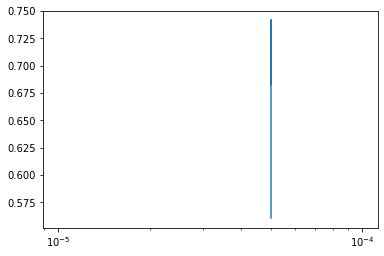

In [12]:
# @title lrfinder

# https://towardsdatascience.com/super-convergence-with-just-pytorch-c223c0fc1e51
# https://github.com/davidtvs/pytorch-lr-finder
# # https://arxiv.org/pdf/1506.01186.pdf
# LR range test
# Note the learning rate value when the accuracy starts to
# increase and when the accuracy slows, becomes ragged, or starts to fall
# _/\

# cyclic
# 0.0001-0.001

num_iter=20
start_lr=0.00005
end_lr= 0.01
# train_batches=100
# test_batches=20
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.AdamW(model.parameters(), lr=start_lr, betas=(0.9, 0.999), eps=1e-08, weight_decay=0.01)
# optimizer = torch.optim.SGD(model.parameters(), lr=start_lr, momentum=0.9)

# def lrfinder(model, optimizer, loss_fn, train_loader, start_lr=0.0001, end_lr=0.1, num_iter=20, train_batches=100, test_batches=20):
def lrfinder(model, optimizer, loss_fn, train_loader, test_loader, start_lr=0.0001, end_lr=0.1, num_iter=20):
    batch_size=64
    train_batches, test_batches = 100, 20
    train_lengths=[batch_size*train_batches,len(train_dataset)-batch_size*train_batches]
    test_lengths=[batch_size*test_batches,len(test_dataset)-batch_size*test_batches]
    # print(train_size,test_size) #50000 10000

    for g in optimizer.param_groups: g['lr'] = start_lr

    acc_list=[]
    lr_list=[]
    num_batches=int(np.ceil(len(train_dataset)/batch_size))
    gamma = np.exp(np.log(end_lr/start_lr)/num_iter)
    # gamma = np.exp(np.log(1e-4/1e-2)/(num_batches*epochs)) # for scheduler step every optimizer step
    scheduler = torch.optim.lr_scheduler.ExponentialLR(optimizer, gamma=gamma)
    import copy
    model1=copy.deepcopy(model)
    optimizer = torch.optim.AdamW(model1.parameters(), lr=start_lr, betas=(0.9, 0.999), eps=1e-08, weight_decay=0.01)
    
    for t in range(num_iter):
        train_sets = torch.utils.data.random_split(train_dataset, train_lengths)[0] # https://stackoverflow.com/a/55760170
        test_sets = torch.utils.data.random_split(test_dataset, test_lengths)[0]
        train_loaders = torch.utils.data.DataLoader(train_sets, batch_size=batch_size, shuffle=True, num_workers=4, pin_memory=True)
        test_loaders = torch.utils.data.DataLoader(test_sets, batch_size=batch_size, shuffle=False, num_workers=4, pin_memory=True)
        
        print("iter: ",t)
        lr=optimizer.param_groups[0]["lr"]
        # lr=scheduler.get_last_lr()[0]
        lr_list.append(lr)
        print("lr: ",lr)
        # train(train_loader, model, loss_fn, optimizer)
        # strain(train_loader, model, loss_fn, optimizer, scheduler)
        strain(train_loader, model1, loss_fn, optimizer, verbose=False)
        test(test_loader, model1, loss_fn)

        accuracy = test(test_loader, model1, loss_fn, verbose=False)
        print("accuracy: ",accuracy)
        acc_list.append(accuracy)
        scheduler.step()

    import matplotlib.pyplot as plt
    plt.plot(lr_list,acc_list)
    plt.xscale('log')
    plt.show()
    plt.close()
    return lr_list,acc_list
    # # base_lr ,max_lr


# lr_list, acc_list = lrfinder(model, optimizer, loss_fn, train_loader, start_lr, end_lr, num_iter, train_batches, test_batches)
lr_list, acc_list = lrfinder(model, optimizer, loss_fn, train_loader, test_loader, start_lr, end_lr, num_iter)



In [6]:
plt.plot(acc_list)
plt.xscale('log')
plt.show()
plt.close()


NameError: ignored

In [ ]:

import time
start = time.time()


train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=4, pin_memory=True)
strain(train_loader, model, loss_fn, optimizer, verbose=False)


end = time.time()
print("time: ",end - start)

In [ ]:
# @title plot lr
# https://efficientdl.com/faster-deep-learning-in-pytorch-a-guide


num_batches=int(np.ceil(len(train_dataset)/batch_size))
print(num_batches)

# optimizer = torch.optim.AdamW(model.parameters(), lr=0.001, betas=(0.9, 0.999), eps=1e-08, weight_decay=0.01)
# scheduler = torch.optim.lr_scheduler.OneCycleLR(optimizer, max_lr=0.1, total_steps=total_steps, anneal_strategy='cos')
# scheduler = torch.optim.lr_scheduler.OneCycleLR(optimizer, max_lr=0.1, total_steps=100, anneal_strategy='linear')
epochs=10
steps_per_epoch=10#num_batches
# scheduler = torch.optim.lr_scheduler.OneCycleLR(optimizer, max_lr=0.1, epochs=epochs, steps_per_epoch=steps_per_epoch, anneal_strategy='cos')

optimizer = torch.optim.SGD(model.parameters(), lr = 1e-1, momentum=0.9)
# scheduler = torch.optim.lr_scheduler.ExponentialLR(optimizer, gamma=0.999) # 0.75(20)-0.9(100)
# # gamma^step

num_batches=int(np.ceil(len(train_dataset)/batch_size))
# print(num_batches)
epochs = 10 #5 20

# (1e-5/1e-1)=gamma**(num_batches*epochs)
# print("1e-4?",0.99993**(num_batches*epochs))
gamma = np.exp(np.log(1e-4/1e-1)/(num_batches*epochs))
print("gamma",gamma)
scheduler = torch.optim.lr_scheduler.ExponentialLR(optimizer, gamma=gamma) # 0.75(20)-0.9(100)

# optimizer = torch.optim.SGD(model.parameters(), lr=1e-3, momentum=0.9, weight_decay=1e-6)
# scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, 30)


num_iter=20
start_lr=0.0001
end_lr= 0.1
gamma = np.exp(np.log(end_lr/start_lr)/num_iter)
print("gamma",gamma)

# optimizer = torch.optim.AdamW(model.parameters(), lr=start_lr, betas=(0.9, 0.999), eps=1e-08, weight_decay=0.01)
optimizer = torch.optim.SGD(model.parameters(), lr=start_lr, momentum=0.9)
scheduler = torch.optim.lr_scheduler.ExponentialLR(optimizer, gamma=gamma)


lr_list=[]
# # for batch, (x, y) in enumerate(train_loader):
# print("in range ",num_batches*epochs)
# for x in range(num_batches*epochs):
for x in range(num_iter):
    scheduler.step()
    # lr=optimizer.param_groups[0]["lr"]
    lr_list.append(scheduler.get_last_lr()[0])

import matplotlib.pyplot as plt
plt.plot(lr_list)
plt.yscale('log')
plt.show()



In [ ]:
# @title wwwwwwwww
import time
start = time.time()
lr_list=[]
loss_fn = nn.CrossEntropyLoss()

num_batches=int(np.ceil(len(train_dataset)/batch_size))
# print(num_batches)
epochs = 10 #5 20
# (1e-5/1e-1)=gamma**(num_batches*epochs)
# gamma = np.exp(np.log(1e-3/1e-1)/epochs) # for scheduler step every epoch
gamma = np.exp(np.log(1e-4/1e-2)/(num_batches*epochs)) # for scheduler step every optimizer step
# print(gamma)

# # optimizer = torch.optim.SGD(model.parameters(), lr=1e-3)
optimizer = torch.optim.SGD(model.parameters(), lr = 1e-1, momentum=0.9)
# scheduler = torch.optim.lr_scheduler.ExponentialLR(optimizer, gamma=gamma) # 0.75(20)-0.9(100)

# optimizer = torch.optim.AdamW(model.parameters(), lr=0.0001, betas=(0.9, 0.999), eps=1e-08, weight_decay=0.01)
# scheduler = torch.optim.lr_scheduler.OneCycleLR(optimizer, max_lr=0.1, total_steps=10, anneal_strategy='cos')
# scheduler = torch.optim.lr_scheduler.OneCycleLR(optimizer, max_lr=0.1, total_steps=num_batches*epochs, anneal_strategy='cos')
# scheduler = optim.lr_scheduler.OneCycleLR(optimizer, 2e-3, epochs=50, steps_per_epoch=len(train_loader))

# scheduler = torch.optim.lr_scheduler.OneCycleLR(optimizer, max_lr=0.1, epochs=epochs, steps_per_epoch=num_batches, anneal_strategy='cos')
for t in range(epochs):
    print(f"Epoch {t+1}\n-------------------------------")
    lr=optimizer.param_groups[0]["lr"]
    lr_list.append(lr)
    print(lr)
    # train(train_loader, model, loss_fn, optimizer)
    # scheduler.step()
    # strain(train_loader, model, loss_fn, optimizer, scheduler)
    strain(train_loader, model, loss_fn, optimizer)

    test(test_loader, model, loss_fn)
print("Done!")

end = time.time()
print("time: ",end - start)

torch.save(model.state_dict(), "model.pth")

# model = NeuralNetwork().to(device)
# model.load_state_dict(torch.load("model.pth"))


In [ ]:
import matplotlib.pyplot as plt
plt.plot(loss_list)
# plt.yscale('log')
plt.show()

plt.plot(lr_list)
plt.show()
